In [1]:
import sys
sys.path.append('C:\\projects\\UTNCE\\src\\utnce202402')

In [2]:
from simplify import *
from prepare import *
from routing import *
from percolation_plot import *
from generate import *
from transfer import *
from copy import deepcopy
from shapely.geometry import Point
from pyproj import Proj, Transformer
import pickle
import itertools
import random
from sympy import symbols, Eq, solve

In [3]:
osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.large.pbf"

# Bus-Amsterdam

## Generate bus networks

In [4]:
city_bus_stations, edges, nodes, city_bus_routes = prepare_bus(osm_path)

topology: 100%|████████████████████████████████████████████████████████████████| 71634/71634 [00:09<00:00, 7600.16it/s]


In [5]:
city_bus_stations

osm_id public_transport railway  tram subway   highway  bus  \
9        45989456         platform    None  None   None  bus_stop  yes   
186     290955154         platform    None  None   None  bus_stop  yes   
238     311831619         platform    None  None   None  bus_stop  yes   
239     311831882         platform    None  None   None  bus_stop  yes   
243     318147070         platform    None  None   None  bus_stop  yes   
...           ...              ...     ...   ...    ...       ...  ...   
3846  10951641134    stop_position    None  None   None      None  yes   
3847  10951641135    stop_position    None  None   None      None  yes   
3850  10951641138    stop_position    None  None   None      None  yes   
3851  10951641142    stop_position    None  None   None      None  yes   
3853  10951641144    stop_position    None  None   None      None  yes   

                            name                  geometry     geo_x  \
9                     Nesserlaan  POINT (4.83890 52.27701)  4.838900   
186                 Badhoevelaan  POINT (4.79002 52.34049)  4.790015   
238                Oostzanerdijk  POINT (4.88103 52.42043)  4.881026   
239                Oostzanerdijk  POINT (4.88145 52.42022)  4.881446   
243                Kometensingel  POINT (4.88289 52.41662)  4.882885   
...                          ...                       ...       ...   
3846              Amsterdam, Dam  POINT (4.89149 52.37455)  4.891493   
3847      Amsterdam, Museumplein  POINT (4.88082 52.35868)  4.880820   
3850     Amsterdam, Parnassusweg  POINT (4.86883 52.33925)  4.868826   
3851  Arent Janszoon Ernststraat  POINT (4.86903 52.33164)  4.869026   
3853                  Kronenburg  POINT (4.87053 52.31653)  4.870530   

          geo_y  
9     52.277010  
186   52.340489  
238   52.420431  
239   52.420219  
243   52.416617  
...         ...  
3846  52.374554  
3847  52.358677  
3850  52.339245  
3851  52.331642  
3853  52.316525  

[3088 rows x 11 columns]

In [6]:
# city_bus_stations.to_excel('.\city_bus_stations.xlsx',header = True, index = False)

In [7]:
city_bus_edges = pd.DataFrame(edges.copy())
city_bus_nodes = pd.DataFrame(nodes.copy())

In [8]:
city_bus_routes = city_bus_routes.loc[city_bus_routes.network == 'Stadsvervoer Amsterdam']
city_bus_routes = city_bus_routes.loc[city_bus_routes.service != 'night']

In [9]:
city_bus_routes, check_name = check_bus_routes(city_bus_stations, city_bus_routes)

In [10]:
replacement_dict = {
    'Amsterdam, ': '',
    'Amsterdam': '',
    'Weesp Station': 'Station',
    'Osdorp De Aker': 'Matterhorn',
    'Schiphol, Airport/Plaza': 'Schiphol, Airport',
    'De Boelelaan': 'De Boelelaan/De Klencke'
}
replacement_dict1 = {
    'Amsterdam, ': '',
    'Amsterdam': '',
}

city_bus_stations['name'] = city_bus_stations['name'].replace(replacement_dict1, regex=True).str.strip()

city_bus_stations, city_bus_routes, check_name = recheck_bus_routes(replacement_dict, city_bus_stations, city_bus_routes)

In [11]:
# Create a dictionary mapping bus routes to their starting station names
city_bus_start_station_name_dict = start_station_dict(city_bus_routes)

# Create a dictionary mapping bus lines to their line information
city_bus_line_dict = line_dict(city_bus_routes)

# Create a list of all station names
city_bus_all_stations_name = all_station_list(city_bus_stations)

# Create a dictionary mapping bus lines to the ordered route of stations
city_bus_order_route_dict = order_stations_inline(city_bus_line_dict, city_bus_all_stations_name, city_bus_routes, city_bus_start_station_name_dict)

# Create a dictionary mapping bus lines to their ordered ID pairs
city_bus_order_id_pairs = id_pairs_inline(city_bus_line_dict, city_bus_order_route_dict, nodes)

# Create the ground graph
G = create_ground_graph(city_bus_edges, city_bus_nodes)

# Create copies of dictionaries to store the analyzed data
city_bus_all_shortest_paths_id_dict = city_bus_order_id_pairs.copy()

# Iterate over each line in the bus order ID pairs
for line in city_bus_order_id_pairs.keys():
    # Compute all shortest paths for the line
    city_bus_all_shortest_paths_id_dict[line] = all_shortest_path_id_list(G, city_bus_order_id_pairs[line], city_bus_edges)

In [12]:
city_bus_order_route_dict

{'Bus 15: Amsterdam Station Zuid => Amsterdam Station Sloterdijk':     id                   name                      geometry     geo_x  \
 0    6           Station Zuid  POINT (4.8720355 52.3408188)  4.872035   
 1    3    Prinses Irenestraat  POINT (4.8682898 52.3428941)   4.86829   
 2   10           Olympiaplein   POINT (4.865862 52.3462864)  4.865862   
 3    8             Olympiaweg  POINT (4.8583469 52.3452468)  4.858347   
 4   28  Haarlemmermeerstation  POINT (4.8576315 52.3492179)  4.857632   
 5   22             Zeilstraat  POINT (4.8566667 52.3512098)  4.856667   
 6   21        Amstelveenseweg  POINT (4.8560722 52.3513667)  4.856072   
 7    1         Hoofddorpplein  POINT (4.8503895 52.3520264)   4.85039   
 8   20   Haarlemmermeerstraat  POINT (4.8503138 52.3554125)  4.850314   
 9   23          Surinameplein  POINT (4.8521842 52.3580689)  4.852184   
 10  26        Corantijnstraat  POINT (4.8532685 52.3617315)  4.853269   
 11  24             Postjesweg    POINT (4.853

In [22]:
city_bus_all_shortest_paths_id_dict

{'Bus 15: Amsterdam Station Zuid => Amsterdam Station Sloterdijk': [14779,
  37419,
  31004,
  31001,
  14780,
  14825,
  7987,
  14830,
  14823,
  14824,
  67476,
  67476,
  15019,
  14821,
  14822,
  15018,
  7960,
  7961,
  15352,
  28865,
  68203,
  68204,
  68204,
  43753,
  43751,
  7977,
  7921,
  7920,
  43739,
  68195,
  68196,
  68196,
  43744,
  10165,
  43747,
  31033,
  68341,
  68341,
  31034,
  63515,
  63516,
  46780,
  46781,
  29032,
  68268,
  68268,
  16444,
  68266,
  68266,
  44968,
  10092,
  18402,
  18398,
  10252,
  18399,
  14550,
  10156,
  10151,
  10060,
  67396,
  67396,
  10267,
  10241,
  67474,
  68265,
  68265,
  10257,
  10552,
  10235,
  10236,
  45148,
  45149,
  68276,
  68276,
  45156,
  45155,
  45160,
  45152,
  45153,
  68285,
  68284,
  68284,
  45196,
  45195,
  68282,
  32034,
  45191,
  44251,
  68281,
  68281,
  68234,
  44252,
  68233,
  68233,
  44246,
  44243,
  68230,
  67329,
  67329,
  68237,
  68236,
  68236,
  44244,
  44253,
  68

In [13]:
city_bus_ordered_edges = edges_revise_direction(city_bus_all_shortest_paths_id_dict,city_bus_edges)
city_bus_ordered_edges

from_id  to_id      osm_id  \
0            0      1     4436684   
1            2      3     4495957   
2            4      5     4496429   
3            6  65237     4727308   
4        65237      7     4727308   
...        ...    ...         ...   
71623    65586  65587  1185077512   
71624    65588  65589  1185077519   
71625    65590  65591  1185077520   
71626    65592  65593  1185077524   
71627    65594  65595  1185077528   

                                                geometry  service     id  \
0      LINESTRING (4.9683596 52.3558775, 4.9683345 52...    steps      0   
1      LINESTRING (4.8601784 52.357593, 4.8601399 52....    steps      1   
2      LINESTRING (4.8743983 52.358788, 4.8744747 52....  service      2   
3      LINESTRING (4.9563878 52.377293, 4.9564629 52....     path      3   
4      LINESTRING (4.9564856 52.376881, 4.9564944 52....     path      4   
...                                                  ...      ...    ...   
71623  LINESTRING (4.795149 52.3318873, 4.7953163 52....  service  71623   
71624  LINESTRING (4.7974835 52.3325307, 4.7972201 52...  service  71624   
71625  LINESTRING (4.7967795 52.3323057, 4.7972519 52...  service  71625   
71626  LINESTRING (4.7997017 52.3324389, 4.7997688 52...     path  71626   
71627  LINESTRING (4.7988313 52.3335157, 4.7987286 52...  service  71627   

        distance      time  weights railway         from_to         to_from  
0       4.049164  0.000324        4     bus          (0, 1)          (1, 0)  
1       7.754968  0.000620        7     bus          (2, 3)          (3, 2)  
2      68.807947  0.005505       68     bus          (4, 5)          (5, 4)  
3      46.383298  0.003711       46     bus      (6, 65237)      (65237, 6)  
4       2.090290  0.000167        2     bus      (65237, 7)      (7, 65237)  
...          ...       ...      ...     ...             ...             ...  
71623  29.884042  0.002391       29     bus  (65586, 65587)  (65587, 65586)  
71624  19.267219  0.001541       19     bus  (65588, 65589)  (65589, 65588)  
71625  34.723141  0.002778       34     bus  (65590, 65591)  (65591, 65590)  
71626  65.462451  0.005237       65     bus  (65592, 65593)  (65593, 65592)  
71627  41.888083  0.003351       41     bus  (65594, 65595)  (65595, 65594)  

[73609 rows x 12 columns]

In [14]:
# Extract the edges from the input DataFrame and create a list of tuples with time
od = city_bus_ordered_edges[['from_id', 'to_id', 'time']]
edges_list = []
for i, row in od.iterrows():
    weight_dict = {"weight": row[2]*60}
    tuple_row = (row[0], row[1], weight_dict)
    edges_list.append(tuple_row)
edges_list

[(0.0, 1.0, {'weight': 0.01943598665744528}),
 (2.0, 3.0, {'weight': 0.03722384502805132}),
 (4.0, 5.0, {'weight': 0.33027814590467297}),
 (6.0, 65237.0, {'weight': 0.2226398309370197}),
 (65237.0, 7.0, {'weight': 0.010033393727670372}),
 (8.0, 9.0, {'weight': 0.2072347771759584}),
 (10.0, 11.0, {'weight': 0.010972115115940276}),
 (12.0, 13.0, {'weight': 0.5035769968301506}),
 (14.0, 15.0, {'weight': 3.3558515670312987}),
 (16.0, 29398.0, {'weight': 1.428207997636663}),
 (29398.0, 41112.0, {'weight': 0.5131273986454964}),
 (41112.0, 17.0, {'weight': 1.1828190706205004}),
 (14.0, 20642.0, {'weight': 0.19213719324105294}),
 (20642.0, 18.0, {'weight': 0.26936614586037444}),
 (19.0, 20.0, {'weight': 0.02557331320986398}),
 (21.0, 27262.0, {'weight': 0.07225925639466096}),
 (27262.0, 27260.0, {'weight': 0.41019591892824153}),
 (27260.0, 27265.0, {'weight': 2.5807954663266846}),
 (27265.0, 22.0, {'weight': 0.06695702976652175}),
 (23.0, 24.0, {'weight': 0.07945924221580851}),
 (25.0, 15.0, {

In [15]:
# Extract the nodes from the input GeoDataFrame and create a list of node IDs
nodes_list = nodes.iloc[:,2].tolist()
nodes_list

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [16]:
G = nx.DiGraph()
for _, row in nodes.iterrows():
    node = row['id']  # Assuming 'id' is the node identifier
    geometry = row['geometry']
    x, y = geometry.x, geometry.y
    G.add_node(node, pos=(x, y))
G.add_edges_from(edges_list)

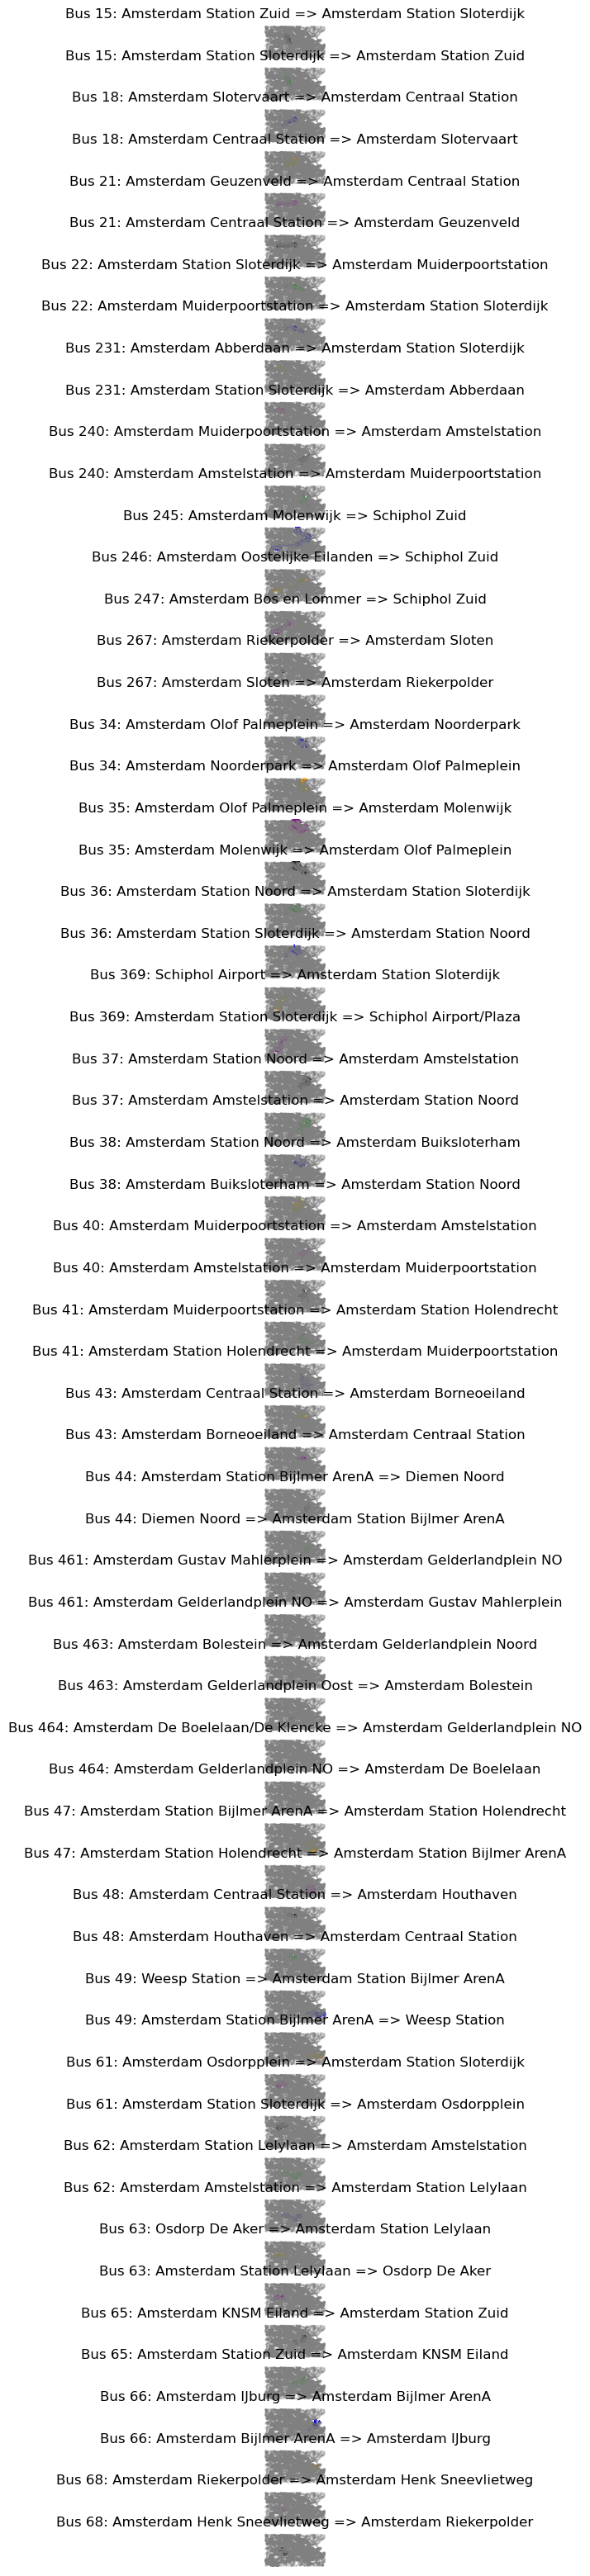

In [17]:
# Create copies of dictionaries to store the analyzed data
city_bus_shortest_path_pairs_dict = city_bus_order_id_pairs.copy()
city_bus_duplicate_row_count = city_bus_order_id_pairs.copy()
city_bus_shortest_path_edges_dict = city_bus_order_id_pairs.copy()
city_bus_edges_dict = city_bus_order_id_pairs.copy()

# Iterate over each line in the bus order ID pairs
for line in city_bus_order_id_pairs.keys():
    # Compute all shortest paths for the line
    city_bus_shortest_path_pairs_dict[line] = all_shortest_paths(G, city_bus_order_id_pairs[line], city_bus_ordered_edges)
    
    # Compute edges with count and weight information for the line
    city_bus_duplicate_row_count[line], city_bus_shortest_path_edges_dict[line], city_bus_edges_dict[line] = edges_with_count_weight(city_bus_shortest_path_pairs_dict[line], city_bus_ordered_edges)

# # Plot the routes with even IDs
# plot_routes_even(city_bus_routes, edges, city_bus_shortest_path_edges)

# # Plot the routes with odd IDs
# plot_routes_odd(city_bus_routes, edges, city_bus_shortest_path_edges)

# Plot all the routes
plot_routes(city_bus_routes, city_bus_ordered_edges, city_bus_shortest_path_edges_dict)

<Axes: >

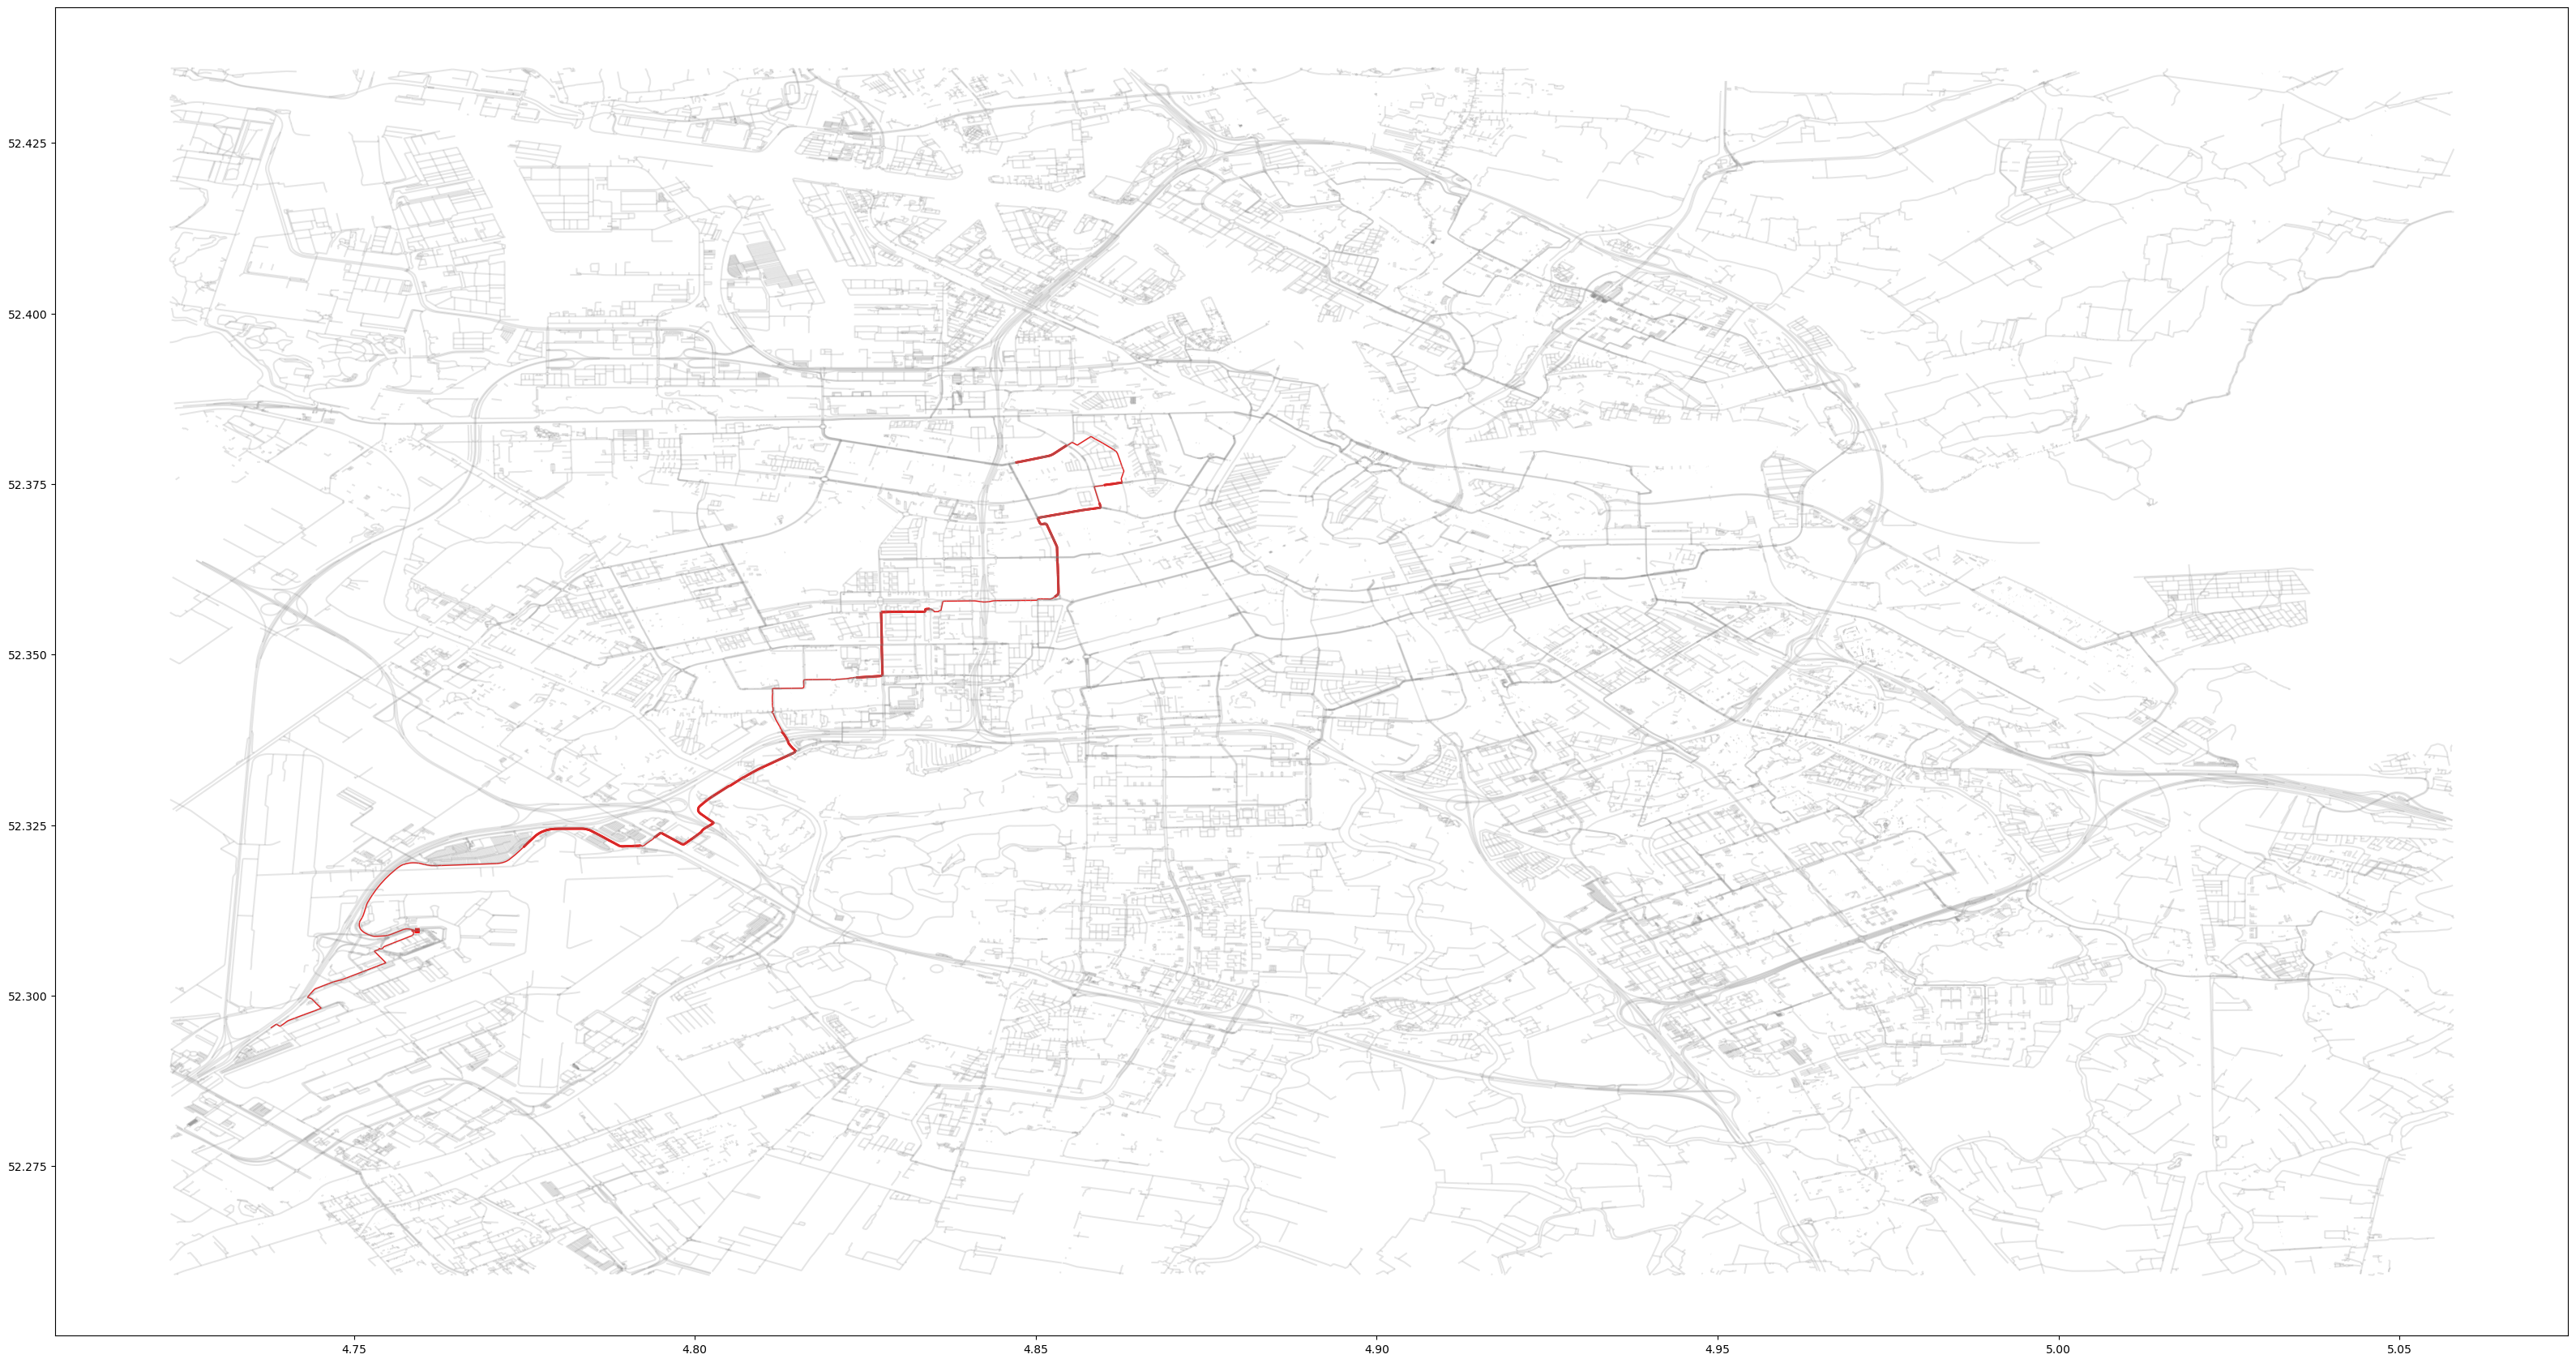

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(40, 40))
gpd.GeoDataFrame(city_bus_ordered_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)
gpd.GeoDataFrame(city_bus_shortest_path_edges_dict['Bus 247: Amsterdam Bos en Lommer => Schiphol Zuid'].copy()).plot(ax=ax, zorder=1,
                                                                     linewidth=(city_bus_shortest_path_edges_dict['Bus 247: Amsterdam Bos en Lommer => Schiphol Zuid'].count_weight),
                                                                     color='red')

<Axes: >

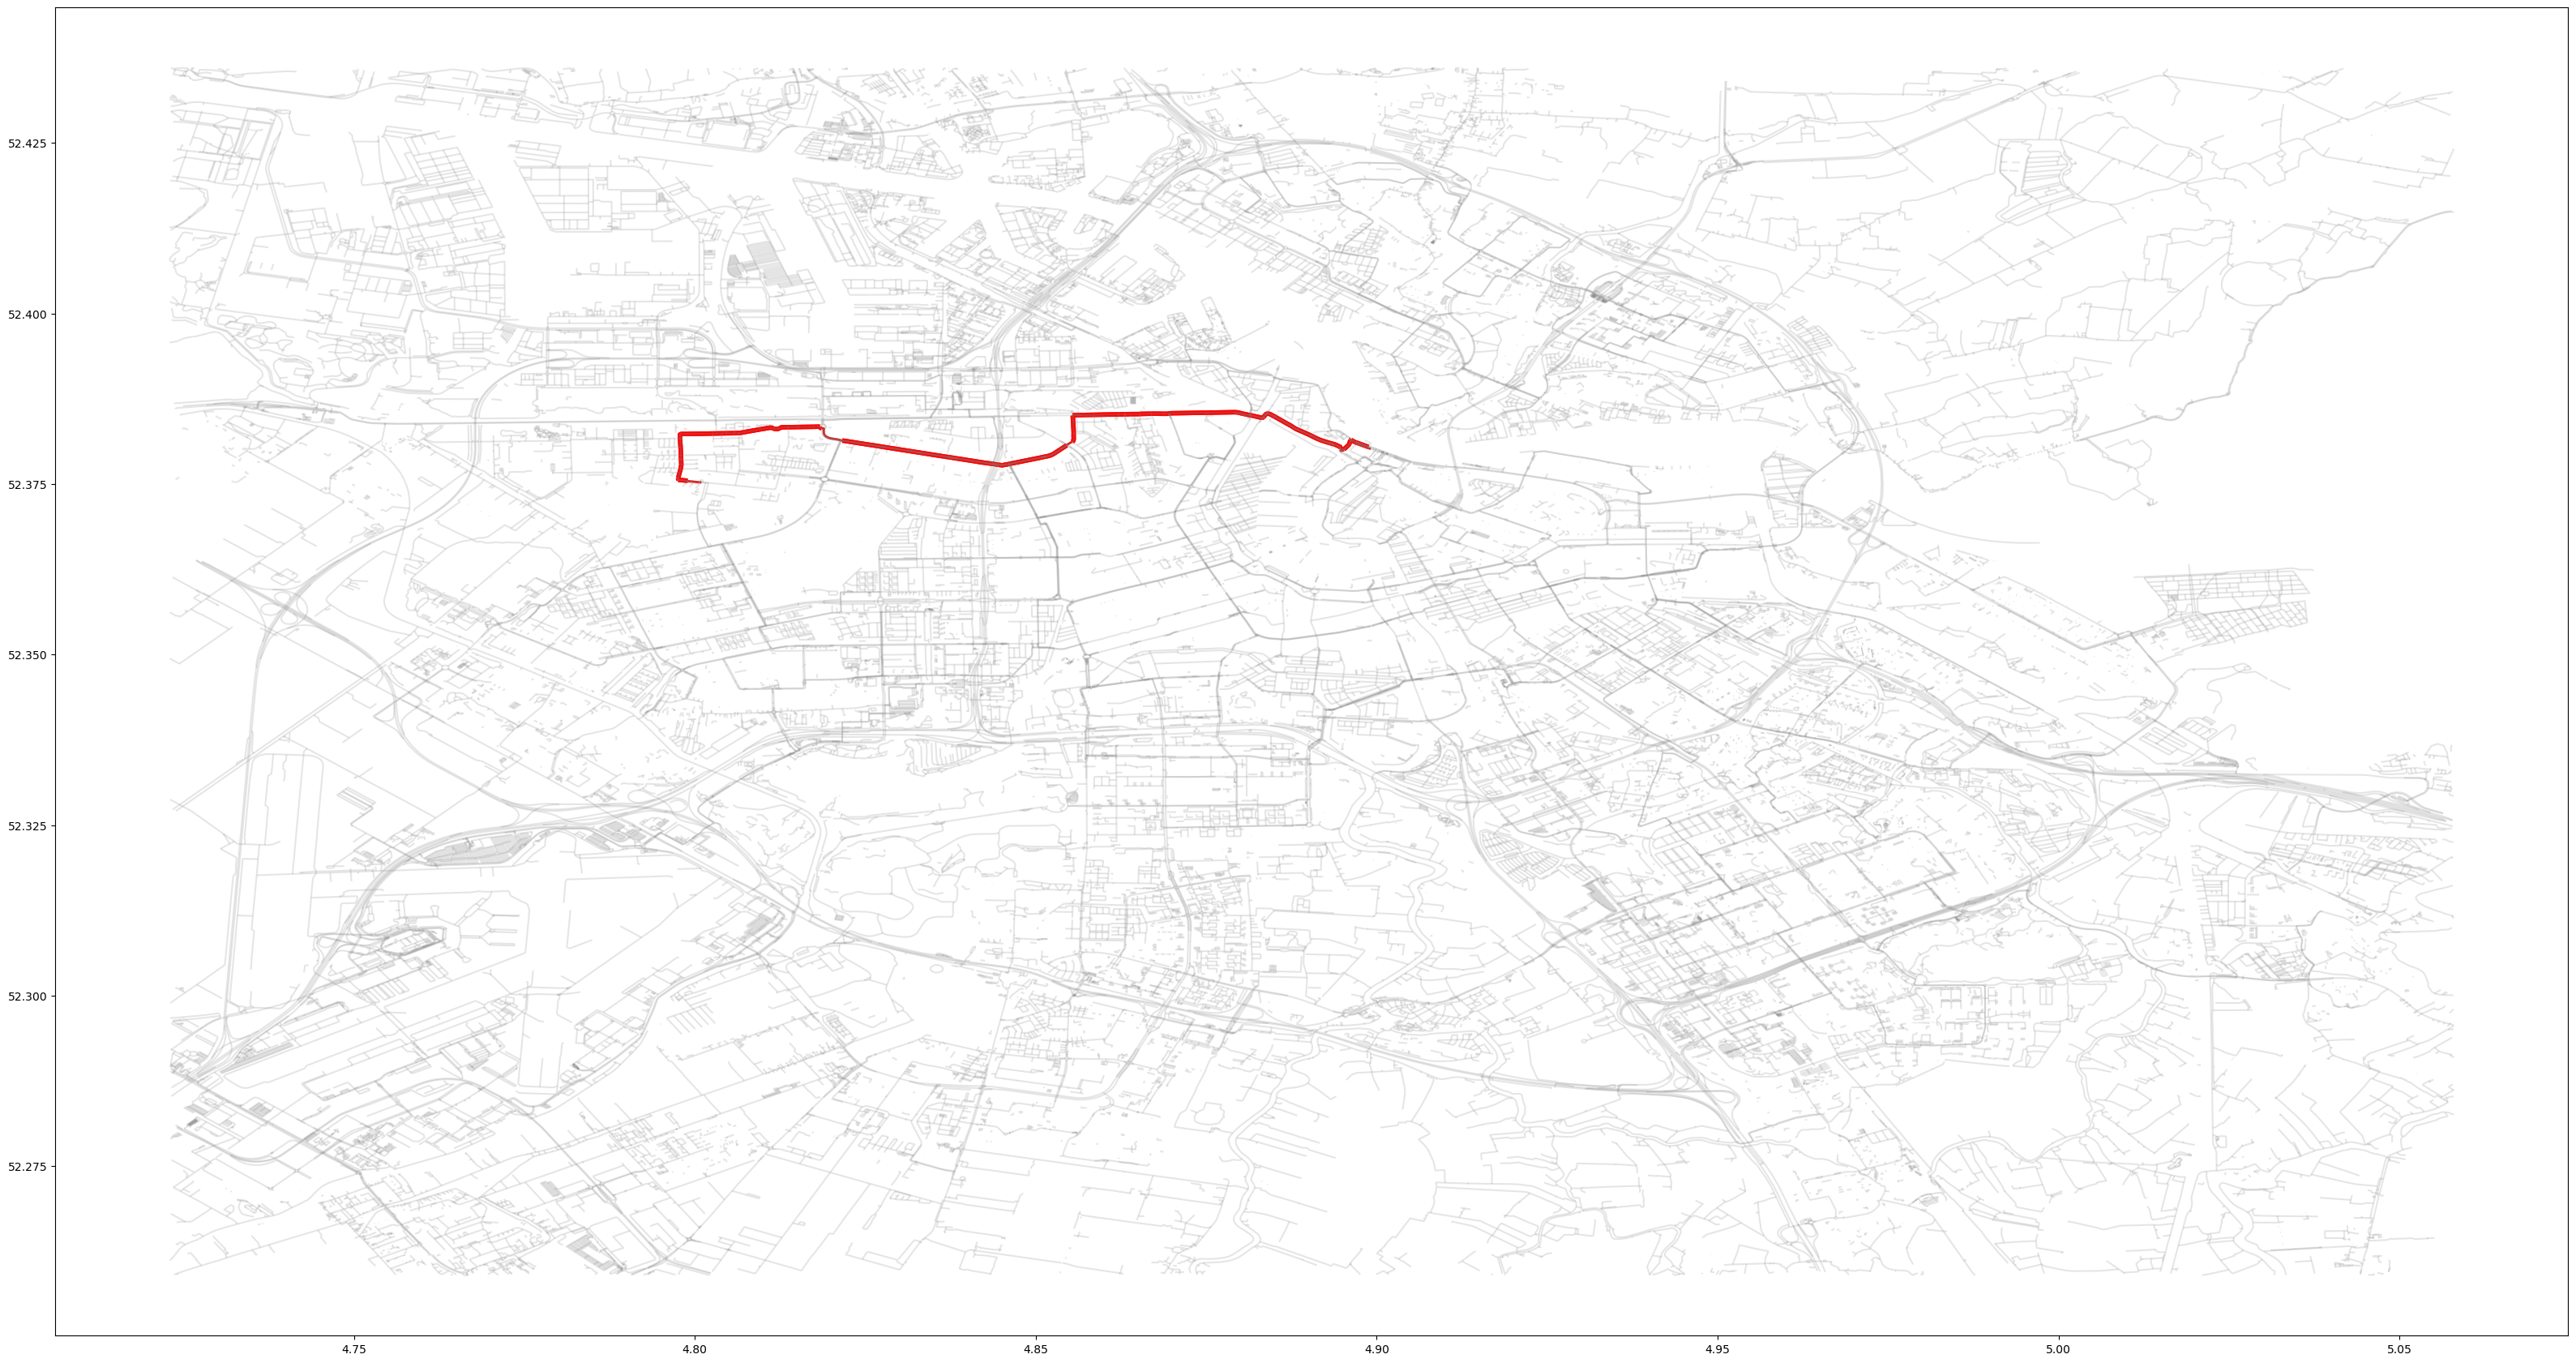

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(40, 40))
gpd.GeoDataFrame(city_bus_ordered_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)
gpd.GeoDataFrame(city_bus_shortest_path_edges_dict['Bus 21: Amsterdam Centraal Station => Amsterdam Geuzenveld'].copy()).plot(ax=ax, zorder=1,
                                                                     linewidth=(city_bus_shortest_path_edges_dict['Bus 21: Amsterdam Centraal Station => Amsterdam Geuzenveld'].count_weight) * 2,
                                                                     color='red')

In [ ]:
len(city_bus_order_route_dict)

In [ ]:
bus_edges

## Add columns to nodes

In [67]:
city_bus_order_route_dict = add_ref_to_orderroutes_or_shortestpath_dict(city_bus_order_route_dict, city_bus_routes)

In [68]:
city_bus_order_route_dict

{'Bus 15: Amsterdam Station Zuid => Amsterdam Station Sloterdijk':     id                   name                      geometry     geo_x  \
 0    6           Station Zuid  POINT (4.8720355 52.3408188)  4.872035   
 1    3    Prinses Irenestraat  POINT (4.8682898 52.3428941)   4.86829   
 2   10           Olympiaplein   POINT (4.865862 52.3462864)  4.865862   
 3    8             Olympiaweg  POINT (4.8583469 52.3452468)  4.858347   
 4   28  Haarlemmermeerstation  POINT (4.8576315 52.3492179)  4.857632   
 5   22             Zeilstraat  POINT (4.8566667 52.3512098)  4.856667   
 6   21        Amstelveenseweg  POINT (4.8560722 52.3513667)  4.856072   
 7    1         Hoofddorpplein  POINT (4.8503895 52.3520264)   4.85039   
 8   20   Haarlemmermeerstraat  POINT (4.8503138 52.3554125)  4.850314   
 9   23          Surinameplein  POINT (4.8521842 52.3580689)  4.852184   
 10  26        Corantijnstraat  POINT (4.8532685 52.3617315)  4.853269   
 11  24             Postjesweg    POINT (4.853

In [69]:
city_bus_new_nodes = add_columns_to_nodes(city_bus_order_route_dict, city_bus_nodes)

In [70]:
city_bus_new_nodes

geometry  degree     id                   name     geo_x  \
0    POINT (4.87204 52.34082)       2  14779           Station Zuid  4.872035   
1    POINT (4.86829 52.34289)       2  67476    Prinses Irenestraat  4.868290   
2    POINT (4.86586 52.34629)       2  68204           Olympiaplein  4.865862   
3    POINT (4.85835 52.34525)       2  68196             Olympiaweg  4.858347   
4    POINT (4.85763 52.34922)       2  68341  Haarlemmermeerstation  4.857632   
..                        ...     ...    ...                    ...       ...   
752  POINT (4.99474 52.35561)       2  67471         Diemerparklaan  4.994741   
753  POINT (4.82444 52.34041)       3  15699    John M. Keynesplein  4.824444   
754  POINT (4.82789 52.34108)       2  11244                    IBM  4.827888   
755  POINT (4.82867 52.34260)       3  26843             Parkeerdek  4.828668   
756  POINT (4.83306 52.34574)       2  31909      Henk Sneevlietweg  4.833059   

         geo_y         coordinate_value  \
0    52.340819  (4.8720355, 52.3408188)   
1    52.342894  (4.8682898, 52.3428941)   
2    52.346286   (4.865862, 52.3462864)   
3    52.345247  (4.8583469, 52.3452468)   
4    52.349218  (4.8576315, 52.3492179)   
..         ...                      ...   
752  52.355608   (4.9947414, 52.355608)   
753  52.340413    (4.824444, 52.340413)   
754  52.341080   (4.827888, 52.3410803)   
755  52.342595  (4.8286682, 52.3425954)   
756  52.345742  (4.8330587, 52.3457424)   

                                       route_name_list route          ref  \
0    Bus 15: Amsterdam Station Zuid => Amsterdam St...   bus   15, 62, 65   
1    Bus 15: Amsterdam Station Zuid => Amsterdam St...   bus  15, 246, 65   
2    Bus 15: Amsterdam Station Zuid => Amsterdam St...   bus           15   
3    Bus 15: Amsterdam Station Zuid => Amsterdam St...   bus           15   
4    Bus 15: Amsterdam Station Zuid => Amsterdam St...   bus       15, 62   
..                                                 ...   ...          ...   
752  Bus 66: Amsterdam Bijlmer ArenA => Amsterdam I...   bus           66   
753  Bus 68: Amsterdam Riekerpolder => Amsterdam He...   bus      267, 68   
754  Bus 68: Amsterdam Riekerpolder => Amsterdam He...   bus      267, 68   
755  Bus 68: Amsterdam Riekerpolder => Amsterdam He...   bus           68   
756  Bus 68: Amsterdam Riekerpolder => Amsterdam He...   bus           68   

        transfer  
0     15, 62, 65  
1    15, 246, 65  
2           None  
3           None  
4         15, 62  
..           ...  
752         None  
753      267, 68  
754      267, 68  
755         None  
756         None  

[757 rows x 11 columns]

### retrive all transfer stations on each route

In [71]:
city_bus_transfer_stations_df = all_transfer_stations_df(city_bus_new_nodes)

In [72]:
city_bus_transfer_stations_df

geometry  degree     id                   name     geo_x  \
0    POINT (4.87204 52.34082)       2  14779           Station Zuid  4.872035   
1    POINT (4.86829 52.34289)       2  67476    Prinses Irenestraat  4.868290   
4    POINT (4.85763 52.34922)       2  68341  Haarlemmermeerstation  4.857632   
5    POINT (4.85667 52.35121)       2  68268             Zeilstraat  4.856667   
6    POINT (4.85607 52.35137)       2  68266        Amstelveenseweg  4.856072   
..                        ...     ...    ...                    ...       ...   
740  POINT (4.96581 52.31983)       0  66747             Tulastraat  4.965810   
741  POINT (4.97152 52.32169)       0  67123      Annie Romeinplein  4.971517   
742  POINT (4.97323 52.32306)       2  67461     Station Ganzenhoef  4.973228   
753  POINT (4.82444 52.34041)       3  15699    John M. Keynesplein  4.824444   
754  POINT (4.82789 52.34108)       2  11244                    IBM  4.827888   

         geo_y         coordinate_value  \
0    52.340819  (4.8720355, 52.3408188)   
1    52.342894  (4.8682898, 52.3428941)   
4    52.349218  (4.8576315, 52.3492179)   
5    52.351210  (4.8566667, 52.3512098)   
6    52.351367  (4.8560722, 52.3513667)   
..         ...                      ...   
740  52.319830    (4.96581, 52.3198302)   
741  52.321685  (4.9715166, 52.3216851)   
742  52.323056   (4.9732278, 52.323056)   
753  52.340413    (4.824444, 52.340413)   
754  52.341080   (4.827888, 52.3410803)   

                                       route_name_list route          ref  \
0    Bus 15: Amsterdam Station Zuid => Amsterdam St...   bus   15, 62, 65   
1    Bus 15: Amsterdam Station Zuid => Amsterdam St...   bus  15, 246, 65   
4    Bus 15: Amsterdam Station Zuid => Amsterdam St...   bus       15, 62   
5    Bus 15: Amsterdam Station Zuid => Amsterdam St...   bus       15, 62   
6    Bus 15: Amsterdam Station Zuid => Amsterdam St...   bus  15, 246, 62   
..                                                 ...   ...          ...   
740  Bus 66: Amsterdam Bijlmer ArenA => Amsterdam I...   bus   41, 47, 66   
741  Bus 66: Amsterdam Bijlmer ArenA => Amsterdam I...   bus       41, 66   
742  Bus 66: Amsterdam Bijlmer ArenA => Amsterdam I...   bus       41, 66   
753  Bus 68: Amsterdam Riekerpolder => Amsterdam He...   bus      267, 68   
754  Bus 68: Amsterdam Riekerpolder => Amsterdam He...   bus      267, 68   

        transfer  
0     15, 62, 65  
1    15, 246, 65  
4         15, 62  
5         15, 62  
6    15, 246, 62  
..           ...  
740   41, 47, 66  
741       41, 66  
742       41, 66  
753      267, 68  
754      267, 68  

[351 rows x 11 columns]

In [73]:
len(city_bus_transfer_stations_df)

351

## Add columns to edges

In [74]:
city_bus_shortest_path_edges = add_ref_to_orderroutes_or_shortestpath_dict(city_bus_shortest_path_edges_dict, city_bus_routes)

In [75]:
city_bus_shortest_path_edges

{'Bus 15: Amsterdam Station Zuid => Amsterdam Station Sloterdijk':          osm_id                                           geometry  \
 0      26956728  LINESTRING (4.8720355 52.3408188, 4.8717707 52...   
 1      26956728  LINESTRING (4.8717707 52.3408097, 4.8716246 52...   
 2      26956728  LINESTRING (4.8705601 52.3407731, 4.8702988 52...   
 3      26956728  LINESTRING (4.8702988 52.3407626, 4.868856 52....   
 4      26982261  LINESTRING (4.8685173 52.3409372, 4.8684681 52...   
 ..          ...                                                ...   
 123   935010194  LINESTRING (4.8435054 52.3848361, 4.8436903 52...   
 124  1020818639  LINESTRING (4.8438138 52.3847277, 4.8438383 52...   
 125  1020818640  LINESTRING (4.8428612 52.3848254, 4.8435054 52...   
 126  1020818641  LINESTRING (4.8438898 52.3843611, 4.8439048 52...   
 127  1147115688  LINESTRING (4.8438493 52.3844829, 4.8438898 52...   
 
            service     id  from_id  to_id    distance      time  weights  \
 0 

In [76]:
city_bus_new_edges = add_columns_to_edges(city_bus_shortest_path_edges,city_bus_ordered_edges)

In [77]:
city_bus_new_edges

osm_id                                           geometry railway  \
0         4436684  LINESTRING (4.9683596 52.3558775, 4.9683345 52...     bus   
1         4495957  LINESTRING (4.8601784 52.357593, 4.8601399 52....     bus   
2         4496429  LINESTRING (4.8743983 52.358788, 4.8744747 52....     bus   
3         4727308  LINESTRING (4.9563878 52.377293, 4.9564629 52....     bus   
4         4727308  LINESTRING (4.9564856 52.376881, 4.9564944 52....     bus   
...           ...                                                ...     ...   
71623  1185077512  LINESTRING (4.795149 52.3318873, 4.7953163 52....     bus   
71624  1185077519  LINESTRING (4.7974835 52.3325307, 4.7972201 52...     bus   
71625  1185077520  LINESTRING (4.7967795 52.3323057, 4.7972519 52...     bus   
71626  1185077524  LINESTRING (4.7997017 52.3324389, 4.7997688 52...     bus   
71627  1185077528  LINESTRING (4.7988313 52.3335157, 4.7987286 52...     bus   

       service     id  from_id  to_id   distance      time  weights  \
0        steps      0        0      1   4.049164  0.000324        4   
1        steps      1        2      3   7.754968  0.000620        7   
2      service      2        4      5  68.807947  0.005505       68   
3         path      3        6  65237  46.383298  0.003711       46   
4         path      4    65237      7   2.090290  0.000167        2   
...        ...    ...      ...    ...        ...       ...      ...   
71623  service  71623    65586  65587  29.884042  0.002391       29   
71624  service  71624    65588  65589  19.267219  0.001541       19   
71625  service  71625    65590  65591  34.723141  0.002778       34   
71626     path  71626    65592  65593  65.462451  0.005237       65   
71627  service  71627    65594  65595  41.888083  0.003351       41   

              to_from         from_to  count_weight route_name_list route  ref  
0              (0, 1)          (1, 0)           NaN             NaN   NaN  NaN  
1              (2, 3)          (3, 2)           NaN             NaN   NaN  NaN  
2              (4, 5)          (5, 4)           NaN             NaN   NaN  NaN  
3          (6, 65237)      (65237, 6)           NaN             NaN   NaN  NaN  
4          (65237, 7)      (7, 65237)           NaN             NaN   NaN  NaN  
...               ...             ...           ...             ...   ...  ...  
71623  (65586, 65587)  (65587, 65586)           NaN             NaN   NaN  NaN  
71624  (65588, 65589)  (65589, 65588)           NaN             NaN   NaN  NaN  
71625  (65590, 65591)  (65591, 65590)           NaN             NaN   NaN  NaN  
71626  (65592, 65593)  (65593, 65592)           NaN             NaN   NaN  NaN  
71627  (65594, 65595)  (65595, 65594)           NaN             NaN   NaN  NaN  

[71628 rows x 16 columns]